In [1]:
import pandas as pd 
import numpy as np 

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import Lasso

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score


In [2]:
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('dataset.csv',index_col=0)

In [4]:
df.head()

,cmlt_daily_game_currency,cmlt_seconds_with_us,cmlt_max_sessions_duration,cmlt_sum_sessions_duration,cmlt_count_sessions,cmlt_sum_quantum_duration,cmlt_count_quant,cmlt_max_quantum_duration,cmlt_max_quant,cmlt_final_level,cmlt_count_grind,cmlt_max_grind,cmlt_count_won_grind,cmlt_hard_buy,cmlt_hard_earn,cmlt_hard_gift,cmlt_hard_spent,cmlt_hard_max_spent,country,country_top_tier,network_name,date_install,first_command_time,cmlt_time_4grind,cmlt_time_with_us_4grind,cmlt_avg_time_for_level,cmlt_avg_duration,cmlt_avg_grind_duration,cmlt_winrate,cmlt_spent_hc_per_grind,cmlt_spent_hc_div_active_time,cmlt_seconds_div_active_time,cmlt_hard_med_spent,birthday,sex,is_cheater,has_email,time_confirm_email,target_game_currency
0,0.0,0,117,234,2,0,0,0,0,1,0,0,0,0,0,15,0,0,RU,0,NaN,2021-03-13,2021-02-07 10:41:50.0,0.000000,0.000000,234.000000,117.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.0
1,0.0,125,668,668,1,1448,4,271,28,1,2,2,2,0,0,15,0,0,MD,0,Facebook Installs,2021-04-22,2021-03-19 23:02:10.0,0.002994,0.016000,668.000000,668.000000,334.000000,1.000000,0.000000,0.000000,62.500000,0.000000,NaN,NaN,False,False,NaN,0.0
2,0.0,14070,4137,15551,12,41220,119,796,275,6,67,69,24,0,5,15,20,16,US,1,Organic,2021-03-24,2021-02-18 19:55:22.0,0.004308,0.004762,2591.833333,1295.916667,232.104478,0.358209,0.298507,0.298507,210.000000,2.857143,1935-10-22,female,False,False,NaN,0.0
3,0.0,0,290,290,1,176,2,44,3,1,1,1,1,0,0,30,0,0,BR,0,Organic,2021-03-25,2021-02-19 16:09:34.0,0.003448,0.000000,290.000000,290.000000,290.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1987-08-08,female,False,True,NaN,0.0
4,0.0,887,1002,1002,1,2448,12,123,121,4,7,7,7,0,2,15,0,0,RU,0,Vungle,2021-04-01,2021-02-26 07:45:15.0,0.006986,0.007892,250.500000,1002.000000,143.142857,1.000000,0.000000,0.000000,126.714286,0.000000,NaN,NaN,False,False,NaN,0.0


# Prepare data

In [5]:
df.drop(['date_install','first_command_time','birthday','sex','time_confirm_email'],axis=1,inplace=True)

In [6]:
int_cols = df.select_dtypes(include=['int', 'float']).columns
int_cols = int_cols.drop('target_game_currency')
obj_cols = ['country','network_name']

In [7]:
def prepare_obj_data_v2(df, obj_cols):
    '''
    Prepare data with type object
    
    Args:
        df: pd.DataFrame
        obj_cols: list of str 
    Returns:
        pd.DataFrame
    '''
    
    cheat_count_is_cheater = df['is_cheater'].value_counts().index[0]
    cheat_count_has_email = df['has_email'].value_counts().index[0]
    
    df['is_cheater'] = df['is_cheater'].fillna(cheat_count_is_cheater)
    df['has_email'] = df['has_email'].fillna(cheat_count_has_email)
    
    df['country'] = df['country'].fillna('other')
    df['network_name'] = df['network_name'].fillna('other')

    encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
    for column in obj_cols:
        encoded_data = encoder.fit_transform(df[[column]])
        encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out([column]))
        df = pd.concat([df, encoded_df], axis=1)
    
    df.drop(obj_cols, axis=1, inplace=True)
        
    return df

In [8]:
df = prepare_obj_data_v2(df, obj_cols)

/Users/kurmangazykarabekov/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/kurmangazykarabekov/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [9]:
X = df.drop('target_game_currency', axis = 1)
y = df['target_game_currency']

In [10]:
y_stratified = (y > 0).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y_stratified, random_state=45)


In [11]:
scaler = StandardScaler()
X_train[int_cols] = scaler.fit_transform(X_train[int_cols])
X_test[int_cols] = scaler.transform(X_test[int_cols])

## Linear Regression

In [12]:
def plot_importance(model, X):
    '''
    Function for plot regression coef
    '''
    try:
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = X.columns
        fold_importance_df["importance"] = model.coef_
        td = fold_importance_df.sort_values('importance', ascending=False)
        sns.barplot(x="importance", y="feature", data=td.head(10), palette="Blues_d")
        plt.show()
    except:
        return []

In [13]:
def SMAPE(y_true, y_pred):
    """
    SMAPE score
    """
    denominator = (np.abs(y_true) + np.abs(y_pred))
    diff = np.where(denominator == 0, 0, 2 * np.abs(y_true - y_pred) / denominator)
    return np.mean(diff)

In [14]:
def train_model(model_obj, X_train, y_train, num_folds ,scoring, cross_val = False):
    '''
    Train model
    '''
    model = model_obj
    print(model.fit(X_train, y_train))
    
    if cross_val:
        cv_scores = cross_val_score(model, X_train, y_train, cv = num_folds, scoring = scoring)
        print("Cross_validation:", cv_scores)
    
    td = plot_importance(model, X_train)
    
    return model, td

Lasso(alpha=5, random_state=42)
Cross_validation: [-796.68182968 -802.16672986 -802.55810945 -826.63149398 -781.44043276]


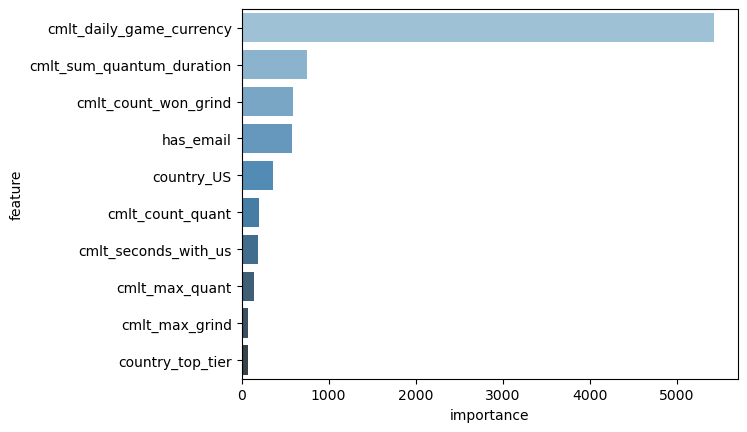

In [19]:
model, features = train_model(
    Lasso(alpha=5, random_state=42),
    X_train, 
    y_train,
    5,
    scoring = "neg_mean_absolute_error",
    cross_val=True)

In [20]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [21]:
print('Train SMAPE: ', SMAPE(y_train, y_pred_train))
print('Test SMAPE: ', SMAPE(y_test, y_pred_test))

print('Train RMSE: ',  np.sqrt(mean_squared_error(y_train, y_pred_train)))
print('Test RMSE: ',  np.sqrt(mean_squared_error(y_test, y_pred_test)))

print('Train MSE: ',  mean_absolute_error(y_train, y_pred_train))
print('Test MSE: ',  mean_absolute_error(y_test, y_pred_test))

Train SMAPE:  1.9718773546837622
Test SMAPE:  1.9711732592673155
Train RMSE:  7700.424539179861
Test RMSE:  8688.087866388945
Train MSE:  798.1714682877787
Test MSE:  812.5957608643329
